# Toxic comment Analysis on Twitter tweets Dataset using LSTM

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys, codecs  
from tqdm import tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs
from keras.preprocessing.text import Tokenizer
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score , confusion_matrix

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
plt.style.use('fivethirtyeight')
print(tf.__version__)
import seaborn as sn
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

2.3.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ranji\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the  Dataset

In [3]:

tweets_train_dataset=pd.read_csv("C:/Users/ranji/Desktop/NLP/Project/twitter hate speech/Code/Dataset/FinalDataset_Train1.csv")
tweets_test_dataset=pd.read_csv("C:/Users/ranji/Desktop/NLP/Project/twitter hate speech/Code/Dataset/FinalDataset_Test1.csv")
tweets_test_dataset.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,label,tweet
0,46745,26678,26678,0,resistance. #job #ruiva #cacheada
1,46746,33358,33358,1,&#8220;@M_Rad: I'm going to miss these bitches...
2,46747,6249,6249,0,ð #tech bitcoin vs. gold [infographic]
3,46748,49095,49095,1,RT @Ronesha__: When I feel like he entertainin...
4,46749,55583,55583,1,bitch betta get it right...shout out....ddaaaw...


In [4]:
x = tweets_train_dataset['tweet']
y = tweets_train_dataset['label']

x_test = tweets_test_dataset['tweet'].values
y_test = tweets_test_dataset['label'].values

### Example of a positive tweet

In [5]:
x[1]

'i am joy. #i_am #positive #affirmation     '

### Example of a negative tweet

In [6]:
x_test[4]

'bitch betta get it right...shout out....ddaaawwgggffaaaccee cccaalldddeerooonn......dese hoes be aktin... http://t.co/FElt4DNd'

<AxesSubplot:xlabel='label', ylabel='count'>

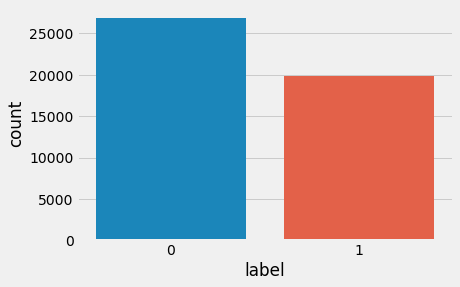

In [7]:
#Class wise count
import seaborn as sns
sns.countplot(x='label', data = tweets_train_dataset)

In [8]:
tweets_train_dataset['label'].value_counts()

0    26853
1    19892
Name: label, dtype: int64

## Loading the Glove word Emembeddings

In [9]:
tweets_train_dataset['doc_len'] = tweets_train_dataset['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(tweets_train_dataset['doc_len'].mean() + tweets_train_dataset['doc_len'].std()).astype(int)

In [10]:
max_features = 20000
max_text_length = 400

In [11]:
print('loading word embeddings...')

#change the path to load the embedding file
embeddings_index = {}
f = codecs.open('C:/Users/ranji/Desktop/NLP/Project/twitter hate speech/Code/Dataset/glove.840B.300d/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

723it [00:00, 7170.82it/s]

loading word embeddings...


2196018it [05:07, 7148.95it/s]

found 2196016 word vectors


## Data Preprocessing and Vectorizing the input data

In [12]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [13]:
from sklearn.utils import shuffle 
print("pre-processing train data...")
raw_docs_train = x.tolist()
raw_docs_test = x_test.tolist() 
num_classes = len(tweets_train_dataset['label'].values)



processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  2%|▏         | 1037/46745 [00:00<00:09, 5065.26it/s]

pre-processing train data...


 11%|█         | 1072/10000 [00:00<00:01, 5349.43it/s]

pre-processing test data...


100%|██████████| 10000/10000 [00:01<00:00, 5282.00it/s]


tokenizing input data...
dictionary size:  70953


## Generating an embedding matrix using our Input data

In [14]:
MAX_NB_WORDS = 100000
#training params
batch_size = 256 
num_epochs = 15

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [15]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38540


In [16]:
print("sample words that are not found in the glove embedding: ", np.random.choice(words_not_found, 10))

sample words that are not found in the glove embedding:  ['tvhostâ\x80¦' 'exploresask' 'thetaylorway'
 'blessedð\x9f\x99\x8fð\x9f\x8f½' 'drunknights' 'postietweet' 'voguet'
 'mrszookeeper' 'saintjohn' 'allzmicelz']


## Defining our LSTM model

In [118]:


model = tf.keras.Sequential()
model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 21, 300)           21286200  
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 64)                85248     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 21,373,561
Trainable params: 87,361
Non-trainable params: 21,286,200
_________________________________________________________________


## Training the model

In [119]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es_callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(word_seq_train, y, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=True)

Epoch 1/15
128/128 [==============================] - 15s 121ms/step - loss: 0.2847 - accuracy: 0.8996 - val_loss: 0.1801 - val_accuracy: 0.9323
Epoch 2/15
128/128 [==============================] - 14s 113ms/step - loss: 0.1703 - accuracy: 0.9378 - val_loss: 0.1584 - val_accuracy: 0.9385
Epoch 3/15
128/128 [==============================] - 14s 113ms/step - loss: 0.1493 - accuracy: 0.9437 - val_loss: 0.1614 - val_accuracy: 0.9397
Epoch 4/15
128/128 [==============================] - 14s 113ms/step - loss: 0.1336 - accuracy: 0.9493 - val_loss: 0.1535 - val_accuracy: 0.9418
Epoch 5/15
128/128 [==============================] - 14s 113ms/step - loss: 0.1208 - accuracy: 0.9539 - val_loss: 0.1549 - val_accuracy: 0.9421
Epoch 6/15
128/128 [==============================] - 15s 113ms/step - loss: 0.1097 - accuracy: 0.9594 - val_loss: 0.1509 - val_accuracy: 0.9432
Epoch 7/15
128/128 [==============================] - 14s 113ms/step - loss: 0.0947 - accuracy: 0.9642 - val_loss: 0.1609 - val_ac

# Model Evaluation

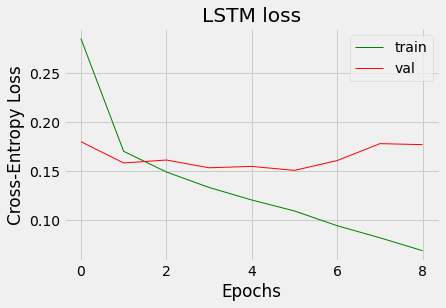

In [120]:
#generate plots
plt.figure()
#positions = [0, 1, 2,3,4,5,6,7]
#labels = ["0", "10", "20","30","40","50", "60", "70"]
#plt.xticks(positions, labels)

plt.plot(history.history['loss'], lw=1.0, color='g', label='train')
plt.plot(history.history['val_loss'], lw=1.0, color='r', label='val')
plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

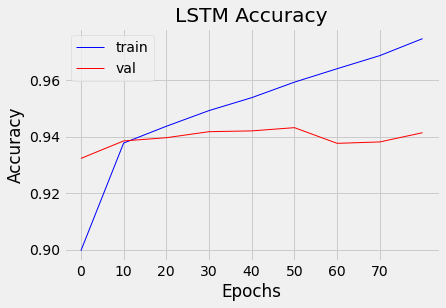

In [121]:
#generate plots
plt.figure()


positions = [0, 1, 2,3,4,5,6,7]
labels = ["0", "10", "20","30","40","50", "60", "70"]
plt.xticks(positions, labels)


plt.plot(history.history['accuracy'], lw=1.0, color='b', label='train')

plt.plot(history.history['val_accuracy'], lw=1.0, color='r', label='val')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [124]:
# testing on test data
y_pred = model.predict(word_seq_test,verbose=1,batch_size=32)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))
print("precision_score: {:.6f}".format(precision_score(y_test, y_pred, average='macro')))
print("recall_score: {:.6f}".format(recall_score(y_test, y_pred, average='macro')))
cm = confusion_matrix(y_test, y_pred)
print(cm)

313/313 [==============================] - 2s 7ms/step
Accuracy: 94.10%
F1 Score: 0.939513
precision_score: 0.940867
recall_score: 0.938322
[[5489  250]
 [ 340 3921]]



Confusion Matrix


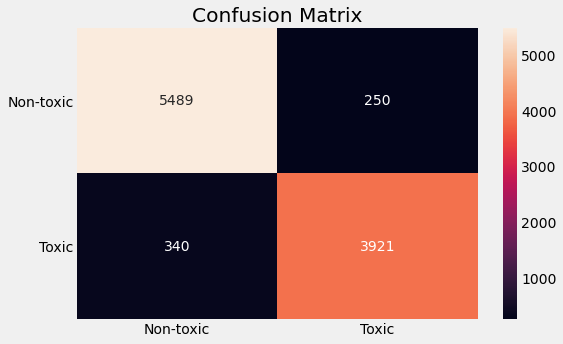

In [125]:
labels = ["Non-toxic", "Toxic"]

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

plt.figure(figsize = (8,5))

print('\nConfusion Matrix')
print('======================================================')
plt.title("Confusion Matrix")

sn.heatmap(df_cm, annot=True, fmt='g')
plt.yticks(rotation = 0)
plt.show()